# MNIST Digit Classification

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [2]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import time
from IPython.display import clear_output

import tf_utils as tfu

import context_learning as ctl
from context_learning.utils import *

In [3]:
strategy = tfu.strategy.gpu(0)

In [61]:
BATCH_SIZE = 512
BATCH_SIZE_PER_REPLICA = BATCH_SIZE//strategy.num_replicas_in_sync

## Dataset

In [62]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = tf.reshape(tf.cast(x_train, tf.float32), (*x_train.shape, 1)) / 255.0
x_test = tf.reshape(tf.cast(x_test, tf.float32), (*x_test.shape, 1)) / 255.0

In [63]:
x_train.shape

TensorShape([60000, 28, 28, 1])

In [64]:
def create_dist_dataset(x, y):
    dataset = tf.data.Dataset.from_tensor_slices((x, y)).batch(BATCH_SIZE)
    dist_dataset = strategy.experimental_distribute_dataset(dataset)
    return dist_dataset

In [65]:
datasets = [
    create_dist_dataset(x_train, y_train),     # standard MNIST
    create_dist_dataset(x_train, 9 - y_train), # 9 - x
]
clear_output()

In [105]:
test_datasets = [
    tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE),     # standard MNIST
    tf.data.Dataset.from_tensor_slices((x_test, 9 - y_test)).batch(BATCH_SIZE), # 9 - x
]
clear_output()

## Model

### Transformer Layers

In [66]:
class BaseTransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, ff_activation="gelu", gating=None, dropout_rate=0.1, prenorm=False):
        super(BaseTransformerBlock, self).__init__()
        self.ffn = keras.Sequential(
            [keras.layers.Dense(ff_dim, activation="gelu"),
             keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(dropout_rate)
        self.dropout2 = keras.layers.Dropout(dropout_rate)
        self.att = self.create_attention_layer(embed_dim, num_heads)
        
        if prenorm:
            self.self_att = self.self_att_prenorm
        else:
            self.self_att = self.self_att_postnorm
        
    def create_attention_layer(self, embed_dim, num_heads):
        raise NotImplemented()
        
    def self_att_prenorm(self, inputs, training):
        inputs_norm = self.layernorm1(inputs)
        attn_output = self.att(inputs_norm, inputs_norm)
        attn_output = self.dropout1(attn_output, training=training)
        attn_output = inputs + attn_output
        
        ffn_norm = self.layernorm2(attn_output)
        ffn_output = self.ffn(ffn_norm)
        ffn_output = self.dropout2(ffn_output, training=training)
        
        return attn_output + ffn_output
    
    def self_att_postnorm(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
        
    def call(self, inputs, training):
        return self.self_att(inputs, training)

In [67]:
class TransformerBlock(BaseTransformerBlock):
    def create_attention_layer(self, embed_dim, num_heads):
        return keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)

In [68]:
class MaskedPositionEmbedding(keras.layers.Layer):
    def __init__(self, maxlen, embed_dim):
        super(MaskedPositionEmbedding, self).__init__()
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen+1,
                                              output_dim=embed_dim,
                                              mask_zero=True)
        self.maxlen = maxlen
        self.embed_dim = embed_dim
        
    def compute_output_shape(self, input_shape):
        return input_shape + (embed_dim,)

    def call(self, x):
        maxlen = tf.shape(x)[-2]
        positions = tf.range(start=1, limit=maxlen+1, delta=1)
        positions = positions * tf.cast(tf.sign(tf.math.count_nonzero(x,axis=2)),tf.int32)
        positions = self.pos_emb(positions)
        return x + positions

### Model Architecture

In [106]:
PATCH_SIZE = 4
EMBED_DIM = 64
FF_DIM = 32
STACK = 5
NUM_HEADS = 4

ATR_DIM = 256
NUM_TASKS = 2
SWITCH_THRESHOLD = -2e-3
ADD_THRESHOLD = -2e-3

In [107]:
with strategy.scope():
    y = x = keras.layers.Input((28, 28, 1))

    # Patches
    y = keras.layers.Conv2D(EMBED_DIM, kernel_size=(PATCH_SIZE, PATCH_SIZE), strides=PATCH_SIZE)(y)
    y = keras.layers.Reshape((-1, EMBED_DIM))(y)

    # Add class token
    class_token = keras.layers.Lambda(lambda x: tf.tile(tf.constant([[0]]), (tf.shape(x)[0],1)))(y)
    class_token = keras.layers.Embedding(input_dim=1, output_dim=EMBED_DIM)(class_token)
    y = keras.layers.Concatenate(axis=1)((class_token, y))
    
    # Transformer Blocks
    y = MaskedPositionEmbedding(y.shape[1], EMBED_DIM)(y)
    for i in range(STACK):
        y = TransformerBlock(EMBED_DIM, NUM_HEADS, FF_DIM)(y)

    # Extract class token
    y = keras.layers.Lambda(lambda x: x[:,0,:])(y)
    
    y = keras.layers.Dropout(0.25)(y)
    y = keras.layers.Dense(EMBED_DIM, activation='gelu')(y)
    
    # Contextualization
    y = keras.layers.Dense(ATR_DIM)(y)
    y = ctl.ContextLayer(switch_threshold=SWITCH_THRESHOLD, add_threshold=ADD_THRESHOLD, verbose=2)(y)
    y = keras.layers.Dense(10, activation="softmax")(y)

    model = ctl.ContextModel(x, y)
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[keras.metrics.SparseCategoricalAccuracy()])
    model.summary()

Model: "context_model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 7, 7, 64)     1088        input_15[0][0]                   
__________________________________________________________________________________________________
reshape_14 (Reshape)            (None, 49, 64)       0           conv2d_14[0][0]                  
__________________________________________________________________________________________________
lambda_28 (Lambda)              (None, 1)            0           reshape_14[0][0]                 
___________________________________________________________________________________

## Training

In [108]:
history = {
    "loss": [],
    "context_loss_x": defaultdict(list),
    "context_loss_y": defaultdict(list),
    "context_delta": [],
}

epoch = -1

train = ctl.make_train_function(eager=False)

In [109]:
REPS = 8
EPOCHS_PER_TASK = 2
num_tasks = 1

with strategy.scope():
    for _ in range(REPS):
        for num_tasks in range(num_tasks, NUM_TASKS + 1):
            for i in np.random.permutation(num_tasks):
                dataset = datasets[i]
                start = epoch + 1
                print("\nDataset:", i)
                for epoch in range(start, epoch+EPOCHS_PER_TASK + 1):
                    while model.perform_epoch(epoch):
                        history["loss"].append(0)
                        for step, batch in enumerate(dataset):
                            loss = train(strategy, model, batch)
                            history["loss"][-1] += loss
                            print(f"\rGlobal Epoch: {epoch}; Epoch: {epoch - start}; Batch: {step+1} Dataset: {i}; Loss: {loss/(step+1)}", end="")
                    history["context_loss_x"][model.context_layers[0].context.value().numpy()].append(epoch)
                    history["context_loss_y"][model.context_layers[0].context.value().numpy()].append(model.context_layers[0].expected_loss().numpy())
                    history["context_delta"].append(model.context_deltas[0].numpy())


Dataset: 0
Global Epoch: 1; Epoch: 1; Batch: 118 Dataset: 0; Loss: 0.0049410536885261536
Dataset: 1
Global Epoch: 2; Epoch: 0; Batch: 118 Dataset: 1; Loss: 0.011943700723350048
Switching contexts...
Force Switching; context delta: -0.00351126306 best fit delta 

Switching to a new context: 1
Global Epoch: 3; Epoch: 1; Batch: 118 Dataset: 1; Loss: 0.0017426906852051616
Dataset: 0
Global Epoch: 4; Epoch: 0; Batch: 118 Dataset: 0; Loss: 0.0024297570344060664
Switching contexts...
Global Epoch: 5; Epoch: 1; Batch: 118 Dataset: 0; Loss: 0.0012536350404843688
Dataset: 0
Global Epoch: 7; Epoch: 1; Batch: 118 Dataset: 0; Loss: 0.0010639851680025458
Dataset: 1
Global Epoch: 8; Epoch: 0; Batch: 118 Dataset: 1; Loss: 0.0016504434170201424
Switching contexts...
Global Epoch: 9; Epoch: 1; Batch: 118 Dataset: 1; Loss: 0.0013278445694595575
Dataset: 0
Global Epoch: 10; Epoch: 0; Batch: 118 Dataset: 0; Loss: 0.0030281646177172664
Switching contexts...
Global Epoch: 11; Epoch: 1; Batch: 118 Dataset: 0

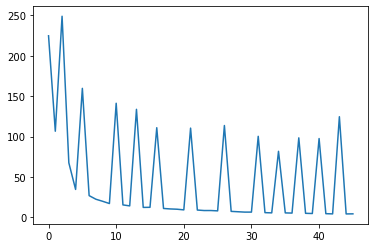

In [110]:
plt.plot(history["loss"])

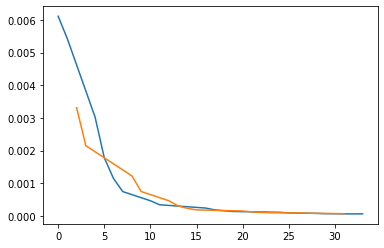

In [111]:
for ctx in history["context_loss_x"]:
    plt.plot(history["context_loss_x"][ctx], history["context_loss_y"][ctx])

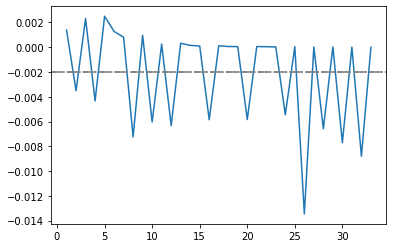

In [112]:
plt.plot(history["context_delta"])
plt.axhline(y=model.context_layers[0].switch_threshold.value(), color="gray", linestyle="--")
plt.axhline(y=model.context_layers[0].add_threshold.value(), color="gray", linestyle="-.")

In [113]:
# Manual selection for now
context_map = [0, 1]

In [114]:
model.context_layers[0].set_context(context_map[0])
model.evaluate(test_datasets[0])

2022-03-21 14:45:51.789882: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_UINT8
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 28
        }
        dim {
          size: 28
        }
        dim {
          size: 1
        }
      }
      shape {
      }
    }
  }
}



20/20 [==============================] - 1s 15ms/step - loss: 0.0697 - sparse_categorical_accuracy: 0.9818


[0.069651760160923, 0.9818000197410583]

In [116]:
model.context_layers[0].set_context(context_map[1])
model.evaluate(test_datasets[1])

 9/20 [============>.................] - ETA: 0s - loss: 0.1068 - sparse_categorical_accuracy: 0.9740

2022-03-21 14:46:24.711277: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_UINT8
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 28
        }
        dim {
          size: 28
        }
        dim {
          size: 1
        }
      }
      shape {
      }
    }
  }
}



20/20 [==============================] - 0s 15ms/step - loss: 0.0711 - sparse_categorical_accuracy: 0.9816


[0.07105779647827148, 0.9815999865531921]